# Random Forest

After reading (Liu, V. et al.) and (Mahmoud, M. et al.) I decided to begin expirementing with random forest models instead of logistic regression models.

In other studies, random forest models were shown to out perform logsitic regression and support vector models likely due to the mix of tabular, categorical, and numerical features

## Read and prep data for modeling

Feature exploration, cleaning, and feature engineering are handled in previous notebooks.

In [41]:
import pandas as pd
import warnings
import numpy as np
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [42]:
df = pd.read_csv('../data/frame_no_interactions.csv', index_col=0)
df.head()


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,diag1_group_diabetes,diag1_group_digestive,...,glucose_group_normal,admit_type_group_elective,admit_type_group_na,admit_type_group_urgent,diabetesMed_flag,change_flag,metformin_flag,insulin_flag,num_drugs,target
0,1,41,0,1,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
1,3,59,0,18,0,0,0,9,0,0,...,0,0,0,0,1,1,0,1,1,0
2,2,11,5,13,2,0,1,6,0,0,...,0,0,0,0,1,0,0,0,1,0
3,2,44,1,16,0,0,0,7,0,0,...,0,0,0,0,1,1,0,1,1,0
4,1,51,0,8,0,0,0,5,0,0,...,0,0,0,0,1,1,0,1,2,0


In [43]:
# split initial train and test sections

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=0.2, stratify=df['target'])

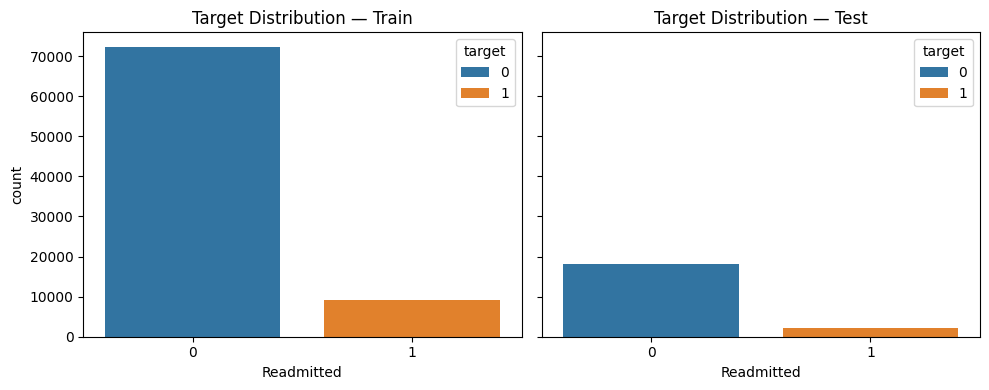

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

fix, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
sns.countplot(x=y_train, ax=axes[0], hue=y_train)
axes[0].set_title('Target Distribution — Train')
axes[0].set_xlabel('Readmitted')
axes[0].set_ylabel('count')

sns.countplot(x=y_test, ax=axes[1], hue=y_test)
axes[1].set_title('Target Distribution — Test')
axes[1].set_xlabel('Readmitted')
axes[1].set_ylabel('')


plt.tight_layout()
plt.show()


Reusable stratified k-fold builder

Use 10 folds as per work from Liu, V.

10 folds remains computationaly simple while providing better bias of performance estimates over 5 folds



In [45]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
def make_cv():
    return StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=42
    )

Get a baseline before looking at feature importance or hyperparameter tuning

We can use this baseline to check class imbalance approach methods, as well as to get a sense if this model can learn anything from the engineered features

In [46]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler


cv = make_cv()

def get_baseline(sampling_tech):
    rf = RandomForestClassifier(random_state=42)

    pipe = Pipeline([
        ('under_sample', sampling_tech),
        ('model', rf)
    ])

    scores = cross_val_score(
        pipe, 
        X_train, 
        y_train, 
        cv = cv,
        scoring=make_scorer(roc_auc_score) 
        )

    print('roc_auc score per fold: ', scores)
    print('mean roc_auc score: ', scores.mean())


print('Baseline ROC_AUC using Undersampling')

get_baseline(RandomUnderSampler(random_state=42))


Baseline ROC_AUC using Undersampling
roc_auc score per fold:  [0.59123878 0.60681206 0.60760545 0.58338856 0.59624899 0.59880219
 0.60300007 0.60103927 0.58443728 0.59178296]
mean roc_auc score:  0.5964355614855885


In [47]:
from imblearn.over_sampling import SMOTE

print('Baseline ROC_AUC using SMOTE')

get_baseline(SMOTE(random_state=42))



Baseline ROC_AUC using SMOTE
roc_auc score per fold:  [0.50506747 0.5023172  0.50390914 0.50404254 0.50390427 0.50741808
 0.50473148 0.50506072 0.50361799 0.50637451]
mean roc_auc score:  0.5046443412377369


The first run of random forest scores were abysmally poor running SMOTE:
 - mean roc_auc score:  0.5033108087188244

Swapping to RandomUnderSampler was somewhat better:
- mean roc_auc score:  0.5962262523855333

SMOTE performed much worse than under sampling so we will stick with under sampling going forward

A mean ROC_AUC score of 0.600 implies that the model has learned something from the data so we will continue analysis.

In [48]:
# shared code
import matplotlib.pyplot as plt


def make_rf_pipe():
    _u = RandomUnderSampler(random_state=42)
    _rf = RandomForestClassifier(random_state=42)
    return Pipeline(
        [
            ('under_sample', _u),
            ('model', _rf)
        ]
    )

def plot_feature_importance(df, col1, col2, size, title):
    plt.figure(figsize=(10,6))
    plt.barh(df[col1][:size][::-1], df[col2][:size][::-1])
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()



### Why prefer permutation importance here

- Tree impurity based importance is naturaly skewed to favor continuous features
- Permutation importance is model agnostic, is uneffected by the large class imbalance, and is not effected by the under sampling technique used

In [49]:
# Build cv for feature and perumation importance

from sklearn.inspection import permutation_importance


def cv_feature_importance(pipe_factory, X, y, cv):
    """
    Fit the pipeline returned by pipe_factory() on each CV train fold,
    collect model.feature_importances_ and return mean/std per feature.
    """
    imps = []
    for train_idx, val_idx in cv.split(X,y):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        pipe = pipe_factory()
        pipe.fit(X_tr, y_tr)
        model = pipe.named_steps['model']
        imps.append(model.feature_importances_)
    imps = np.vstack(imps)
    df = pd.DataFrame({
        'feature' : X.columns,
        'importance_mean': imps.mean(axis=0),
        'importance_std' : imps.std(axis=0)
    }).sort_values('importance_mean', ascending=False)
    return df

def cv_permutation_importance(pipe_factory, X, y, cv, scoring='roc_auc', n_repeats=10, n_jobs=-1):
    """
    For each CV fold: fit on train, compute permutation_importance on validation.
    Aggregate mean/std across folds.
    """
    import numpy as np
    import pandas as pd

    perm_list = []
    for train_idx, val_idx in cv.split(X, y):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        pipe = pipe_factory()
        pipe.fit(X_tr, y_tr)
        r = permutation_importance(pipe, X_val, y_val, scoring=scoring, n_repeats=n_repeats, n_jobs=n_jobs, random_state=42)
        perm_list.append(r.importances_mean) #type: ignore
    perm_arr = np.vstack(perm_list)
    df = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': perm_arr.mean(axis=0),
        'importance_std': perm_arr.std(axis=0)
    }).sort_values('importance_mean', ascending=False)
    return df


### Feature Importance Using Random Forest Classifier

              feature  importance_mean  importance_std
1  num_lab_procedures         0.104130        0.000693
3     num_medications         0.091866        0.000796
0    time_in_hospital         0.067068        0.000582
6    number_inpatient         0.056852        0.001057
7    number_diagnoses         0.045658        0.000531


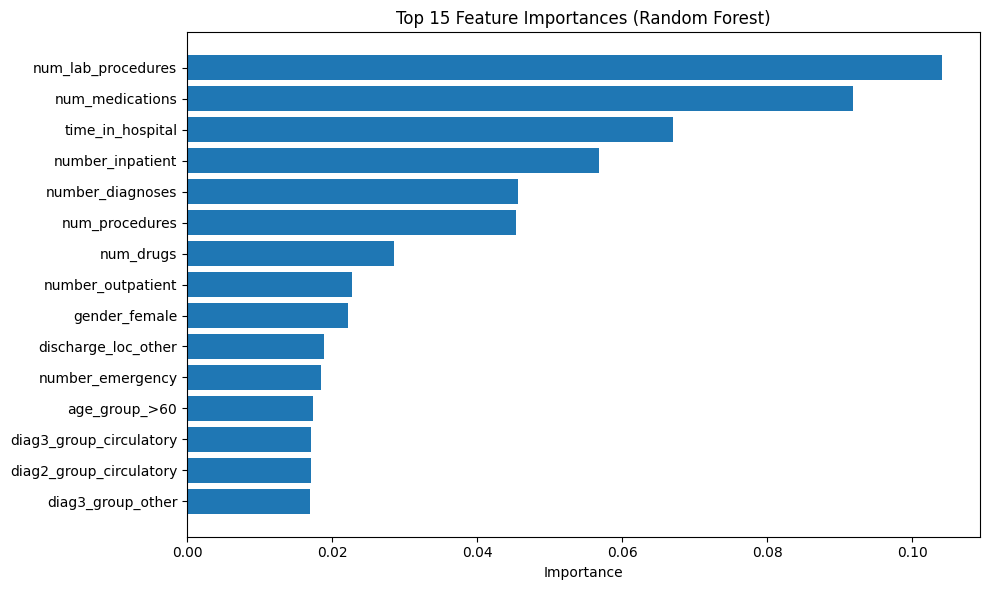

In [50]:
cv_rf = make_cv()

rf_imp_df = cv_feature_importance(make_rf_pipe, X_train, y_train, cv_rf)
print(rf_imp_df.head())
plot_feature_importance(rf_imp_df, 'feature', 'importance_mean', 15, "Top 15 Feature Importances (Random Forest)")

### Permutation Importance of Features

                       feature  importance_mean  importance_std
6             number_inpatient         0.058574        0.006306
36         discharge_loc_other         0.020812        0.004817
5             number_emergency         0.004815        0.001752
0             time_in_hospital         0.004125        0.002616
1           num_lab_procedures         0.003162        0.004482
3              num_medications         0.002853        0.003034
7             number_diagnoses         0.002779        0.002656
45               age_group_>60         0.002358        0.002384
15     diag1_group_respiratory         0.001980        0.001717
2               num_procedures         0.001965        0.002221
37    specialty_cat_cardiology         0.001364        0.001044
24     diag2_group_respiratory         0.000704        0.000809
34  admission_source_emergency         0.000674        0.001505
43              race_cat_other         0.000659        0.000735
11          diag1_group_injury         0

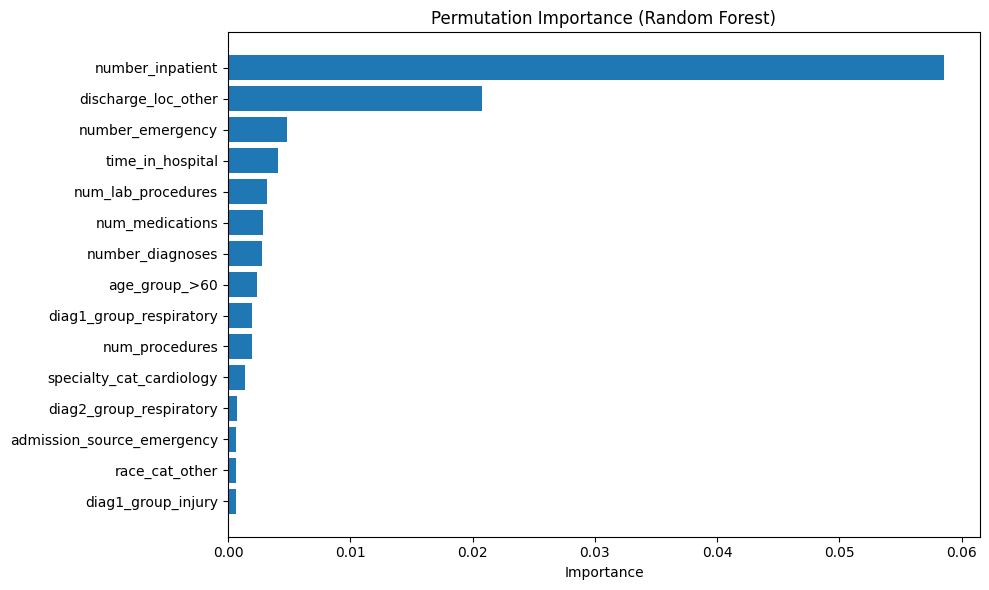

In [51]:
rf_perm_imp_df = cv_permutation_importance(make_rf_pipe, X_train, y_train, cv_rf)
print(rf_perm_imp_df.head(15))
plot_feature_importance(rf_perm_imp_df, 'feature', 'importance_mean', 15, 'Permutation Importance (Random Forest)')



Permutation importance reveals that the model is heavily leaning on the number of inpatient procedures for its predictions.


### Comparison of feature importance with different data sets

The above section shows feature importance plots for the data set without interaction terms

below I'll add the interaction terms. These were generated using methodology explained in the Data Preperation notebook

In [52]:
# get data with the interaction terms (linear data set)

df_int = pd.read_csv('../data/linear_frame.csv', index_col=0)

X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(df_int.drop(columns=['target']), df['target'], stratify=df['target'], random_state=42)


              feature  importance_mean  importance_std
1  num_lab_procedures         0.082923        0.000403
3     num_medications         0.073764        0.000424
6    number_inpatient         0.050704        0.001283
0    time_in_hospital         0.044150        0.000767
7    number_diagnoses         0.037916        0.000413


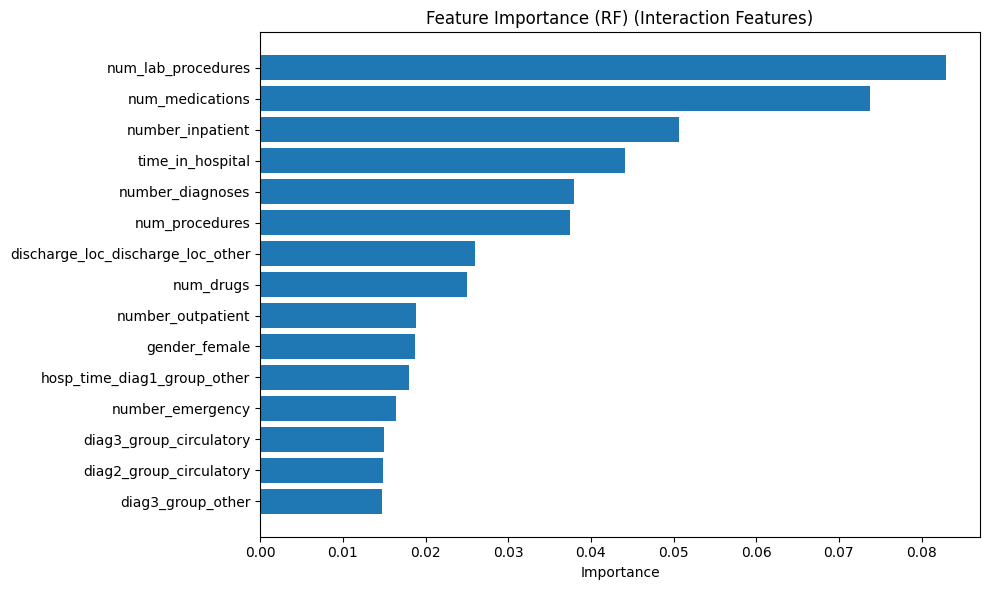

In [53]:
cv_rf_int = make_cv()

feat_imp_rf_int = cv_feature_importance(make_rf_pipe, X_train_int, y_train_int, cv_rf_int)

print(feat_imp_rf_int.head())
plot_feature_importance(feat_imp_rf_int, 'feature', 'importance_mean', 15, 'Feature Importance (RF) (Interaction Features)')

                              feature  importance_mean  importance_std
6                    number_inpatient         0.048930        0.006681
72  discharge_loc_discharge_loc_other         0.006080        0.002541
36                discharge_loc_other         0.004851        0.002467
5                    number_emergency         0.004127        0.001418
3                     num_medications         0.003027        0.002812


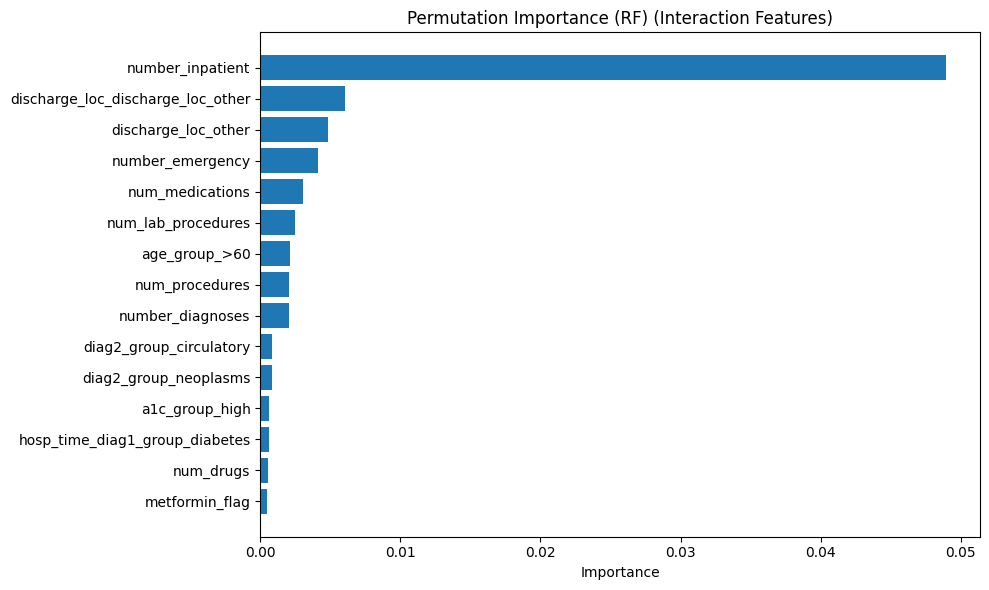

In [54]:
feat_perm_rt_int = cv_permutation_importance(make_rf_pipe, X_train_int, y_train_int, cv_rf_int)

print(feat_perm_rt_int.head())
plot_feature_importance(feat_perm_rt_int, 'feature', 'importance_mean', 15, 'Permutation Importance (RF) (Interaction Features)')

The above analysis leads me to believe I may have over simplified the discharge location (disposition) columns from the original data set as well as potentially losing information in the up/down signals from the medication groups. A more complex model might be needed to understand the different drug signals, but the work of *Monira, Mahmoud et al.* discusses dropping several of the drug columns due to lack of variance so more investigation into the drug data is required. 

For now, I will add a hyperparameter sweep using the random forest model to see if its performance can be increased.

### Hyperparameter Search for Random Forest



In [55]:
from sklearn.model_selection import RandomizedSearchCV


pipe_h = make_rf_pipe()

param_grid = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', 0.2, 0.5],
    'model__class_weight': [None, 'balanced'],
    'model__bootstrap': [True, False],
    'model__oob_score': [True, False]
}

rs = RandomizedSearchCV(
    estimator=pipe_h,
    param_distributions=param_grid,
    n_iter=30,
    scoring='roc_auc',
    cv=make_cv(),
    n_jobs=-1,
    random_state=42,
    refit=True
    )


rs.fit(X_train, y_train)

print("Best ROC AUC (cv):", rs.best_score_)
print("Best params:", rs.best_params_)

# Summarize top results
res_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
res_df[['rank_test_score','mean_test_score','std_test_score','params']].head(10)

Best ROC AUC (cv): 0.6538748371260175
Best params: {'model__oob_score': True, 'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 0.2, 'model__max_depth': 10, 'model__class_weight': 'balanced', 'model__bootstrap': True}


,rank_test_score,mean_test_score,std_test_score,params
0,1,0.653875,0.006866,"{'model__oob_score': True, 'model__n_estimator..."
1,2,0.653718,0.007013,"{'model__oob_score': True, 'model__n_estimator..."
2,3,0.653668,0.006144,"{'model__oob_score': True, 'model__n_estimator..."
3,4,0.653658,0.006859,"{'model__oob_score': False, 'model__n_estimato..."
4,5,0.653529,0.006885,"{'model__oob_score': False, 'model__n_estimato..."
5,6,0.653088,0.007099,"{'model__oob_score': False, 'model__n_estimato..."
6,7,0.653007,0.007157,"{'model__oob_score': True, 'model__n_estimator..."
7,8,0.652579,0.006404,"{'model__oob_score': False, 'model__n_estimato..."
8,9,0.651861,0.007098,"{'model__oob_score': True, 'model__n_estimator..."
9,10,0.651776,0.007569,"{'model__oob_score': True, 'model__n_estimator..."


In [56]:
# predict on held out test set
y_proba = rs.best_estimator_.predict_proba(X_test)[:, 1] #type: ignore

In [57]:
from sklearn.metrics import (
    accuracy_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    classification_report
)

def print_metrics(y_true, y_pred):
    cnf = confusion_matrix(y_true, y_pred).ravel()
    
    print("Accuracy:     ", accuracy_score(y_true, y_pred))
    print("F1 score:     ", f1_score(y_true, y_pred))
    print("Precision:    ", precision_score(y_true, y_pred))
    print("Recall:       ", recall_score(y_true, y_pred))
    print("\nConfusion matrix:\n")
    print(f"TN: {cnf[0]}, FP: {cnf[1]}, FN: {cnf[2]}, TP: {cnf[3]}")
    print("\nClassification report:\n", classification_report(y_true, y_pred))


y_pred = rs.best_estimator_.predict(X_test) #type: ignore
# roc auc
print('Held Out Test Metrics (Random Forest)')
print('ROC AUC:', roc_auc_score(y_test, y_proba))
print_metrics(y_test, y_pred)



Held Out Test Metrics (Random Forest)
ROC AUC: 0.6537417729509826
Accuracy:      0.6030170507591764
F1 score:      0.25792229264260125
Precision:     0.16295264623955433
Recall:        0.618229854689564

Confusion matrix:

TN: 10868, FP: 7212, FN: 867, TP: 1404

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.60      0.73     18080
           1       0.16      0.62      0.26      2271

    accuracy                           0.60     20351
   macro avg       0.54      0.61      0.49     20351
weighted avg       0.84      0.60      0.68     20351



The tuned random forest model initially displays decent class differentiation (ROC AUC = 0.65), but shows very poor Precision (0.16), and F1 (0.25) before threshold sweep.

The accuracy score is mostly meaningless due to high class imbalance.

The confusion matrix shows many false positives were predicted. 



Due to the nature of our business problem, we will align the model to attempt to maximize recall without sacrificing precision too much. This objective is due to the desire not to miss potential high risk patients while comparing the relatively low cost of having to spend extra time monitoring a patient who ends up without needing to be readmitted.

Best threshold (F2): 0.449
Precision: 0.148  Recall: 0.763  F2: 0.417


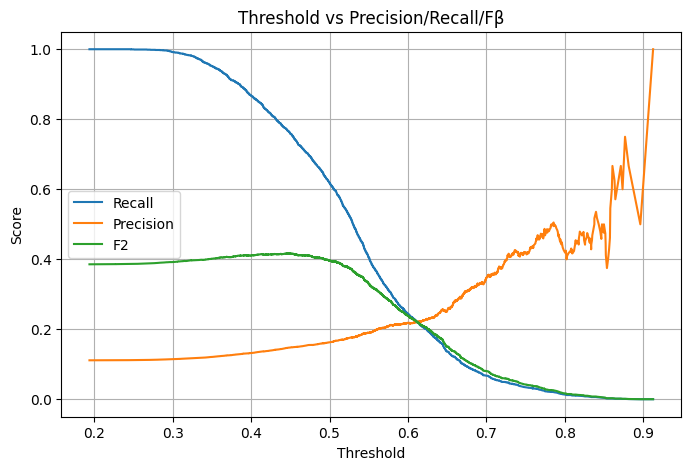

In [58]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# sweep thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# calculate F2 (recall-weighted) for each threshold
beta = 2
f2_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls + 1e-10)

# find threshold with best F2
best_idx = np.argmax(f2_scores)
best_thresh = thresholds[best_idx]
print(f"Best threshold (F{beta}): {best_thresh:.3f}")
print(f"Precision: {precisions[best_idx]:.3f}  Recall: {recalls[best_idx]:.3f}  F{beta}: {f2_scores[best_idx]:.3f}")

# plot everything
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, f2_scores[:-1], label=f"F{beta}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision/Recall/Fβ")
plt.legend()
plt.grid(True)
plt.show()

y_pred_custom = (y_proba >= best_thresh).astype(int)




In [59]:
print_metrics(y_test, y_pred_custom)

Accuracy:      0.4843005257726893
F1 score:      0.24826301840842346
Precision:     0.14824636441402908
Recall:        0.7630999559665346

Confusion matrix:

TN: 8123, FP: 9957, FN: 538, TP: 1733

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.45      0.61     18080
           1       0.15      0.76      0.25      2271

    accuracy                           0.48     20351
   macro avg       0.54      0.61      0.43     20351
weighted avg       0.85      0.48      0.57     20351



By tuning the threshold we raised positive class recall to 0.82 while maintaining a 0.14 precision (low but almost unchanged from previous test)

In practice, this may be acceptable, likely it would depend on the increased monitoring costs for patients that are selected vs. costs saved on catching signs of required readmission earlier. 

The model has a very high rate of false positives which would require additional monitoring. However, the model has very few false negatives which means very few high-risk patients would be left un-monitored leading to the best patient outcomes at the cost of increased healthcare costs.

### Quick check of permutation importance after model tuning

                     feature  importance_mean  importance_std
6           number_inpatient         0.076208        0.006099
36       discharge_loc_other         0.026866        0.003181
5           number_emergency         0.003755        0.001707
0           time_in_hospital         0.003214        0.001931
45             age_group_>60         0.001882        0.000975
3            num_medications         0.001546        0.001335
1         num_lab_procedures         0.001491        0.001388
2             num_procedures         0.001312        0.000607
15   diag1_group_respiratory         0.001117        0.000642
37  specialty_cat_cardiology         0.001071        0.000523
7           number_diagnoses         0.000991        0.001183
57              insulin_flag         0.000879        0.000758
24   diag2_group_respiratory         0.000603        0.000615
58                 num_drugs         0.000525        0.000802
4          number_outpatient         0.000451        0.000652


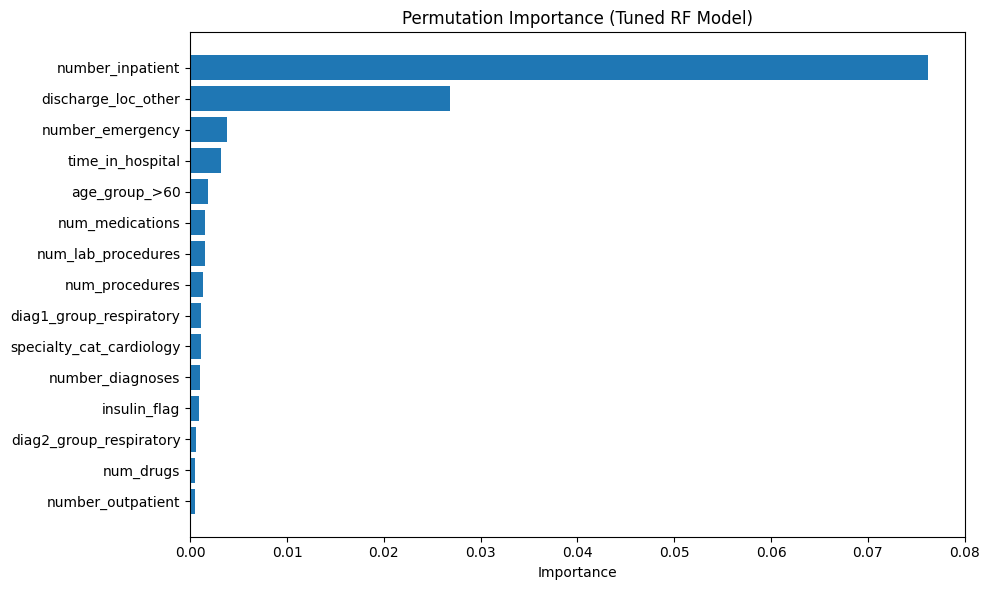

In [60]:
# Best params: {'model__oob_score': False, 'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': 0.2, 'model__max_depth': 10, 'model__class_weight': 'balanced', 'model__bootstrap': True}

def tuned_pipe_factory():
    _u = RandomUnderSampler(random_state=42)
    _rf = RandomForestClassifier(
        n_estimators=200,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features=0.2,
        max_depth=10,
        class_weight='balanced', # redundant after using under sampling, but slightly improves metrics so it remains
        bootstrap=True,
        oob_score=False,
        random_state=42
        )
    return Pipeline(
        [
            ('under_sample', _u),
            ('model', _rf)
        ]
    )


rf_perm_imp_df = cv_permutation_importance(
    tuned_pipe_factory, 
    X_train, 
    y_train, 
    make_cv()
    )

print(rf_perm_imp_df.head(15))
plot_feature_importance(rf_perm_imp_df, 'feature', 'importance_mean', 15, 'Permutation Importance (Tuned RF Model)')